# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 3.5. Трансформеры для Named Entity Recognition`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__27 марта 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__06 апреля 05:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий)

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В рамках этого задания вы научитесь:
1. Загружать датасеты и претренированные модели из [Hugging face Hub](https://huggingface.co)
2. Манипулировать текстовыми датасетами с помощью библиотеки [datasets](https://huggingface.co/docs/datasets/index)
3. Запускать и обучать трансформеры с помощью библиотеки [transformers](https://huggingface.co/docs/transformers/index)
4. Промптить большую языковую модель на примере [Qwen2.5-7B-Instruct](https://huggingface.co/Qwen/Qwen2.5-7B-Instruct)
5. Оптимизировать гиперпараметры с помощью библиотеки [optuna](https://optuna.org/)

При выполнении задания вы будете решать стандартную задачу классификации токенов: распознавание именованных сущностей.

Задание состоит из трёх частей:
1. Обработка данных и работа с датасетами из Hugging Face.
2. Практика больших языковых моделей.
3. Дообучение трансформера.

Обратите свое внимание на [официальный гайд](https://huggingface.co/learn/nlp-course/chapter7/2), в котором подробно разбирается задача классификации токенов.

## `Часть 1. Загрузка и предобработка (4 балла)`

### `Подготовка среды Kaggle`

**Хранение ключей**: Kaggle Secrets --- инструмент для безопасного хранения и использования в ноутбуках Kaggle API-ключей, паролей или токенов.

Для добавления нового ключа:
1. Перейдите в Add-ons --> secrets
2. Add secret для добавления нового ключа. Доступ к ключу из ноутбука осуществляется с помощью пакета kaggle_secrets
3. Коллекция ключей общая для всех ноутбуков пользователя на kaggle. Но в каждом ноутбуке необходимо выбрать ключи, которые будут доступны через kaggle_secrets

Ниже находится пример подгрузки ключей для kaggle и wandb.

In [ ]:
# from kaggle_secrets import UserSecretsClient
# import os

# api_keys = UserSecretsClient()

# os.system(f"huggingface-cli login --token {api_keys.get_secret('huggingface-cli')}")
# os.system(f"wandb login {api_keys.get_secret('wandb')}")

**Установка домашнего каталога**: Если мы хотим контролировать путь, по которому будут загружаться датасеты, чекпоинты моделей и т.д., то стоит задать переменную среды `HF_HOME`. При использовании kaggle перемещение домашнего каталога huggingface в директорию working позволит избежать повторной загрузки при перезапуске ноутбука (не забудьте установить "persistence: files only" в настройках kaggle-ноутбука)

In [ ]:
# Optional

# os.environ['HF_HOME'] = '/kaggle/working/hf_hub'

### `Подготовка среды Google Colab`

Секреты можно настроить в колабе:

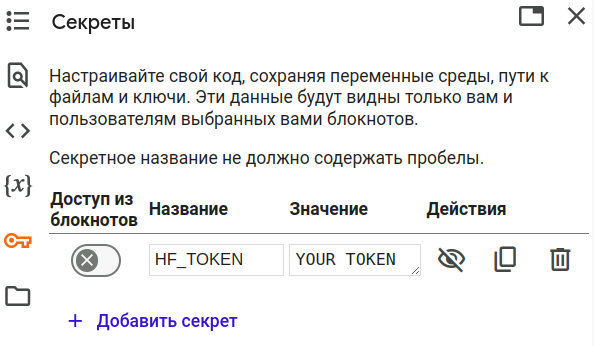

In [1]:
from google.colab import userdata
import os

hf_token = userdata.get('huggingface-cli')
wandb_token = userdata.get('wandb')
os.system(f"huggingface-cli login --token {hf_token}")
os.system(f"wandb login {wandb_token}")

0

### `Общая подготовка`

In [2]:
# pip offers the --quiet / -q option to silence output

! pip install transformers[torch] datasets autoawq evaluate seqeval optuna -q

При работе с библиотеками часто бывает важно соблюдение версий. Задание тестировалось на Python 3.12 при версиях библиотек указанных ниже.

In [3]:
!pip freeze > requirements.txt
!cat requirements.txt | grep torch

torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl


In [4]:
!cat requirements.txt | grep transformers
!cat requirements.txt | grep datasets
!cat requirements.txt | grep autoawq
!cat requirements.txt | grep evaluate
!cat requirements.txt | grep seqeval
!cat requirements.txt | grep optuna

sentence-transformers==3.4.1
transformers==4.50.3
datasets==3.5.0
tensorflow-datasets==4.9.8
vega-datasets==0.9.0
autoawq==0.2.7.post3
evaluate==0.4.3
seqeval==1.2.2
optuna==4.2.1


In [5]:
import gc
import json
import random
from typing import Any, Union
from pathlib import Path

import numpy as np
import numpy.typing as npt

import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TextGenerationPipeline,
    pipeline,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from transformers.trainer_callback import EarlyStoppingCallback

import optuna
import evaluate

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

In [6]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

set_global_seed(42)

На протяжении всего задания вы можете добавлять любой `import`, иногда, это и являются частью задания. При работе с большими библиотеками очень важно уметь читать документацию и использовать гугл для поиска информации.

Для выполнения задания необходимо использование GPU!

In [7]:
if not torch.cuda.is_available():
    print("You need GPU!!!")

### `Загрузка данных (0.25 балла)`

В первую очередь, Hugging Face --- это хаб с датасетами и моделями. Загрузите готовый датасет [отсюда](https://huggingface.co/datasets/voorhs/conll2003-corrupted).

Подсказка: почитайте [туториал](https://huggingface.co/docs/datasets/load_hub).

*Если не получится сразу, то лучше перед следующими попытками перезапустить ноутбук.*

In [8]:
# YOUR CODE IS HERE
from datasets import load_dataset

dataset = load_dataset('voorhs/conll2003-corrupted')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/309k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

**Вопрос**: Какие поля нам доступны? Напечатайте пару примеров из каждого сплита. Попытайтесь догадаться какой смысл имеет каждое поле и опишите в двух словах.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/access).

In [9]:
# YOUR CODE IS HERE
print(dataset)
num = [100, 200]
for i in num:
  print(dataset['train'][i])
  print(dataset['validation'][i])
  print(dataset['test'][i])
  print('\n')

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})
{'id': '584', 'tokens': ['Scorers', ':'], 'pos_tags': [24, 8], 'chunk_tags': [11, 0], 'ner_tags': ['O', 'O']}
{'id': '100', 'tokens': ['Attendance', ':', '200'], 'pos_tags': [21, 8, 11], 'chunk_tags': [11, 0, 11], 'ner_tags': ['O', 'O', 'O']}
{'id': '100', 'tokens': ['Ijaz', 'Ahmad', 'c', 'Spearman', 'b', 'Vaughan', '59'], 'pos_tags': [22, 22, 34, 22, 34, 22, 11], 'chunk_tags': [11, 12, 0, 11, 0, 11, 12], 'ner_tags': ['B-PER', 'I-PER', 'O', 'B-PER', 'O', 'B-PER', 'O']}


{'id': '10468', 'tokens': ['CHICAGO', '64', '65', '.496', '5'], 'pos_tags': [22, 11, 11, 11, 11], 'chunk_tags': [11, 12, 12, 12

**Ответ:**
Доступные поля в датасете:
* id: уникальный идентификатор для каждого примера
* tokens: токены в предложении
* pos_tags: метки частей речи (глагол, существительное, запятая, точка, цифра и тд)
* chunk_tags: метки синтаксических групп (глагольная группа, существительная группа и тд), используеся, для того, чтобы учитывать, что названия (синтаксические группы) могут быть из нескольких слов (11 - начало группы, 12 - ее продолжение)
* ner_tags: метки именованных сущностей (имя, локация и тд), с соответсвующей разметкой (о которой сказано ниже)



### `Удаление колонок (0.25 балла)`

Мы будем предсказывать NER tags непосредственно по тексту. Остальная информация нам не понадобится. Удалите все колонки кроме `tokens` и `ner_tags`.

*Подсказка:* почитайте [туториал](https://huggingface.co/docs/datasets/process#remove).

In [10]:
# YOUR CODE IS HERE
temp = ['id', 'pos_tags', 'chunk_tags']
dataset = dataset.remove_columns(temp)
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

### `Сбор тегов (0.25 балла)`

Обратите внимание,что в датасете представлена **BIO-разметка**.

**BIO-разметка** -- это способ аннотации текста для распознавания именованных сущностей (NER), где **B** (Beginning) обозначает начало сущности, **I** (Inside) — продолжение той же сущности, а **O** (Outside) — отсутствие сущности.

Например, в предложении *"Apple выпустила новый iPhone"* разметка будет: *"Apple/B-ORG выпустила/O новый/O iPhone/B-PRODUCT"*.

В предложении  *"Билл Гейтс основал Microsoft"* -- *"Билл/B-PER Гейтс/I-PER основал/O Microsoft/B-ORG"*.

**Такой формат помогает моделям точно определять границы и типы сущностей.**



Прежде чем работать с датасетом, необходимо понять, какие именно NER-теги присутствуют в данных. Напечатайте все уникальные значения NER-тегов, которые встречаются в датасете.

*Подсказка:* по датасету можно итерироваться с помощью конструкции `for ... in`

**Вопрос:**
- есть ли какие-то подозрительные теги, которых быть не должно?

In [11]:
# YOUR CODE IS HERE
all_tags = set()
for split in dataset.keys():
    for elem in dataset[split]:
        all_tags.update(elem['ner_tags'])
print(all_tags)

{'MISSING', 'B-LOC', 'I-PER', 'O', 'I-LOC', 'B-MISC', 'B-ORG', 'I-MISC', 'I-ORG', 'B-PER'}


**ОТВЕТ**: подозрительные тэги: MISSING

Для вычисления лосс функции и подсчета метрик нам потребуется перевести теги в классы, так как мы будем решать задачу классификации.

Создайте мапинги тегов:
- `label2id`: строковое представление тега (например `B-PER`) -> индекс класса
- `id2label`: наоборот

Исключите из них подозрительные теги, которых не должно быть.

*Подсказка:* должно получиться 9 тегов

In [12]:
# YOUR CODE IS HERE
valid_tags = [tag for tag in all_tags if tag != 'MISSING']
valid_tags.sort()
label2id = {name: i for i, name in enumerate(valid_tags)}
label2id

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-MISC': 5,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 8}

In [13]:
id2label = {i: tag for tag, i in label2id.items()}
id2label

{0: 'B-LOC',
 1: 'B-MISC',
 2: 'B-ORG',
 3: 'B-PER',
 4: 'I-LOC',
 5: 'I-MISC',
 6: 'I-ORG',
 7: 'I-PER',
 8: 'O'}

### `Фильтрация (0.25 балла)`

В обучающей выборке для части объектов пропущена разметка. Разделите обучающую выборку на размеченные и неразмеченные объекты. Напечатайте размеры обеих частей.

*Подсказка:* прочитайте [туториал](https://huggingface.co/docs/datasets/process#select-and-filter). Фильрацию датасета можно написать в одну строчку.

In [14]:
# YOUR CODE IS HERE
def filt(row):
  return 'MISSING' in row['ner_tags']

dataset_raw_essential = dataset
dataset_raw_essential["train_missing"] = dataset["train"].filter(filt)
dataset_raw_essential["train"] = dataset["train"].filter(lambda x: not filt(x))

dataset_raw_essential

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4041
    })
})

**ОТВЕТ**:

размер train_missing - 4041

размер train - 10000

In [15]:
assert len(dataset_raw_essential["train_missing"]) == 4041

### `Получение tokenizer-independent представления (2 балла)`

Имеющаяся BIO-разметка построена для токенизатора, который нам, к сожалению, **не известен**. Необходимо построить tokenizer-independent представление нашего датасета.

**Восстановление текста**: Для каждого объекта датасета необходимо объединить токены из `tokens` в единую строку и поместить в поле `text`. Необходимо учесть, что знаки препинания, кавычки и скобки (например, `,`, `.`, `!`. `)`, `"`) не должны иметь пробелов перед собой, но должны иметь пробел после себя.

**Изменение BIO-разметки**: Так как каждый токенизатор по-своему разобьет полученный `text`, то необходимо уметь строить BIO-разметку для любого токенизатора.

По имеющейся BIO-разметке необходимо:
* Оставить только последовательность сущностей, удалив префиксы начала (B- и I-).
* Для каждой именованной сущности найти позиции символов, ей соответствующие (в формате python slice).

Пример результата:
```python
{
    'text': '6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)',
    'tags': ['PER', 'LOC', 'PER','LOC'],
    'ranges': [[4, 16], [19, 23], [30, 44], [47, 55]]
}
```

*Пояснение к примеру*. В тексте `'6 - Andre Agassi (U.S.) vs. Mauricio Hadad (Colombia)'` встретилось четыре сущности:
- `PER` на позициях `[4,16]`, а именно `Andre Agassi`
- `LOC` на позициях `[19,23]`, а именно `U.S.`
- `PER` на позициях `[30,44]`, а именно `Mauricio Hadad`
- `LOC` на позициях `[47,55]`, а именно `Colombia`

**Важно:**
- Полученный результат сохраните на диск (например по пути `./data/generic`)
- Подробности о названиях аргументов и возвращаемых значениях берите из докстринга функции `transform_ner_data`

In [16]:
def transform_ner_data(tokens: list[str], ner_tags: list[str]):
    """
    Obtain tokenizer-independent representation of a single sample.

    Args:
        tokens: list of words, subwords or even punctuations
        ner_tags: list of BIO labels
    Returns:
        sample: dictionary with the following contents:
            - text (str): detokenized sequence
            - tags (list[str]): list of tags names (PER, ORG, LOC, MISC)
            - ranges (list[tuple[int, int]]): list of python slices for each entity
    """

    punctuation_symbols = ("-", "'", ".", ",", ")", ":", ";", '"')

    text = ""
    ranges = []
    tags = []

    # declare vars if you needed
    # YOUR CODE IS HERE
    current_entity_start = -1
    current_entity_tag = ""
    current_entity_end = -1

    for token, tag in zip(tokens, ner_tags):
        # Adjust spacing based on token type
        if len(text) > 0 and not token.startswith(
            punctuation_symbols
        ):
            text += " "

        token_start = len(text)
        text += token

        # Handle entity tagging
        if tag.startswith("B-"):  # Begin a new entity
            # Close the previous entity
            # YOUR CODE IS HERE
             if current_entity_start != -1:
                ranges.append([current_entity_start, token_start])
                tags.append(current_entity_tag)
             current_entity_start = token_start
             current_entity_tag = tag[2:]
             current_entity_end = len(text)

        elif tag.startswith("I-"):  # Continue an entity
            # YOUR CODE IS HERE
            entity_type = tag[2:]
            if entity_type != current_entity_tag:
                if current_entity_start != -1:
                  ranges.append([current_entity_start, token_start])
                  tags.append(current_entity_tag)
                current_entity_start = token_start
                current_entity_tag = entity_type
                current_entity_end = len(text)
            else:
                current_entity_end = len(text)

        else:  # Tag is "O" or unrelated, close any open entity
            # YOUR CODE IS HERE
            if current_entity_start != -1:
                ranges.append([current_entity_start, current_entity_end])
                tags.append(current_entity_tag)
                current_entity_start = -1
                current_entity_tag = ""
                current_entity_end = -1

    # Close any open entity at the end
    # YOUR CODE IS HERE
    if current_entity_start != -1:
        ranges.append([current_entity_start, current_entity_end])
        tags.append(current_entity_tag)

    # Final output
    return {"text": text, "tags": tags, "ranges": ranges}

Проверьте, что все работает:

In [17]:
dataset_generic = dataset_raw_essential.map(
    function=transform_ner_data,
    input_columns=["tokens", "ner_tags"],
    remove_columns=dataset_raw_essential["train"].column_names,
)

dataset_generic

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
})

In [18]:
assert dataset_generic["train"][:3] == {
    "text": [
        "LONDON 1996-08-22",
        "WorldCom, which said it will buy MFS, shed 1-3/4 to close at 21 while MFS lost 3-8/16 to close at 41-5/16.",
        "6- Andre Agassi ( U.S.) vs. Mauricio Hadad ( Colombia)",
    ],
    "tags": [["LOC"], ["ORG", "ORG", "ORG"], ["PER", "LOC", "PER", "LOC"]],
    "ranges": [
        [[0, 6]],
        [[0, 8], [33, 36], [70, 73]],
        [[3, 15], [18, 22], [28, 42], [45, 53]],
    ],
}

Сохраните результат на диск (используйте функции из библиотеки `datasets`):

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# YOUR CODE IS HERE
dataset_generic.save_to_disk("/content/drive/MyDrive/data/generic")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

### `Токенизация (1 балл)`

Для отладки воспользуемся токенизатором модели `google-bert/bert-base-uncased`.

In [21]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
print(bert_tokenizer(dataset_generic["train"]["text"][11]))

{'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


У каждого токенизатора есть свои специальные токены, для получения этой информации можно воспользоваться соотвествующей переменной.

In [23]:
bert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Теперь надо написать функцию, которая по имеющуемуся tokenizer-independent представлению выдает BIO-разметку для предоставленного токенизатора.  Реализуйте функцию `align_tokens_and_tags`, которая трансформирует один объект из датасета. Все подробности о формате входных данных берите из докстринга.

**Важно:** служебные токены, добавляемые токенизатором должны иметь специальный лейбл `SPECIAL_TOKENS_LABEL`, т.к. их не надо учитывать при сборе лосса.

In [24]:
SPECIAL_TOKENS_LABEL = -100


def align_tokens_and_tags(
    text: str, tags: list[str], ranges: list[tuple[int, int]], tokenizer: AutoTokenizer
):
    """
    Align the tokenizer-independent representation with a Hugging Face tokenizer.

    Args:
        text: original text.
        tags: list of entity tags (e.g., ["PER", "LOC"]).
        ranges: list of (start, end) character ranges for each entity.
        tokenizer: A Hugging Face tokenizer.

    Returns:
        dict: A dictionary with `input_ids`, `labels`:
            - input_ids are tokens indices in tokenizer's vocabulary
            - labels are integer labels for BIO tags (from label2id mapping)

    Note:
        This function
    """
    encoding = tokenizer(
        text, return_offsets_mapping=True, truncation=True, padding=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    token_ids = encoding["input_ids"]
    offset_mapping = encoding["offset_mapping"]


    # Initialize BIO tags for each token
    # YOUR CODE IS HERE
    labels = ["O"] * len(tokens)

    for i, token_id in enumerate(token_ids):
        if token_id in tokenizer.all_special_ids:
            labels[i] = SPECIAL_TOKENS_LABEL


    # Map character ranges to token indices
    for tag, (start, end) in zip(tags, ranges):
        # Find tokens that overlap with the entity range
        first_token = True

        for (i, (token_start, token_end)), token_id in zip(
            enumerate(offset_mapping), token_ids
        ):

            # detect no overlap
            # YOUR CODE IS HERE
            if token_id in tokenizer.all_special_ids:
                continue

            if token_end <= start or token_start >= end:
                continue

            # classifier token
            #     hint: use if
            # YOUR CODE IS HERE
            if first_token:
                labels[i] = f"B-{tag}"
                first_token = False
            else:
                labels[i] = f"I-{tag}"

    label_ids = []
    for label in labels:
        if label == SPECIAL_TOKENS_LABEL:
            label_ids.append(SPECIAL_TOKENS_LABEL)
        else:
            label_ids.append(label2id[label])

    return {
        "input_ids": token_ids,
        "labels": label_ids # don't forget to handle special tokens
    }

In [25]:
def tokenize_ner_dataset(
    dataset: Union[datasets.DatasetDict, datasets.Dataset], tokenizer: AutoTokenizer
):
    return dataset.map(
        function=align_tokens_and_tags,
        input_columns=["text", "tags", "ranges"],
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=(
            dataset["train"] if "train" in dataset else dataset
        ).column_names,
    )

Вот пара примеров того, что должно получиться:

In [26]:
for i in range(9, 12):
    sample = dataset_generic["train"][i]
    print("before tokenization:", sample)
    tokenized_sample = align_tokens_and_tags(**sample, tokenizer=bert_tokenizer)
    print("after tokenization:", tokenized_sample)
    print()

before tokenization: {'text': '1-0.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 1015, 1011, 1014, 1012, 102], 'labels': [-100, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Puchon 3 Chonan 0 ( halftime 1-0)', 'tags': ['ORG', 'ORG'], 'ranges': [[0, 6], [9, 15]]}
after tokenization: {'input_ids': [101, 16405, 24561, 1017, 16480, 7229, 1014, 1006, 22589, 1015, 1011, 1014, 1007, 102], 'labels': [-100, 2, 6, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, -100]}

before tokenization: {'text': 'Primary iron output was 297,700 tonnes, 14.5 percent more than last July and 0.1 percent more than in June.', 'tags': [], 'ranges': []}
after tokenization: {'input_ids': [101, 3078, 3707, 6434, 2001, 27502, 1010, 6352, 11000, 1010, 2403, 1012, 1019, 3867, 2062, 2084, 2197, 2251, 1998, 1014, 1012, 1015, 3867, 2062, 2084, 1999, 2238, 1012, 102], 'labels': [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100]}



Тесты:

In [27]:
dataset_tokenized = tokenize_ner_dataset(dataset_generic, bert_tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

In [28]:
assert dataset_tokenized["train"][5:7] == {
    "input_ids": [
        [
            101,
            2002,
            2596,
            2000,
            2031,
            2042,
            2730,
            2006,
            9857,
            2305,
            1010,
            6114,
            2012,
            2560,
            2809,
            17079,
            8710,
            1012,
            102,
        ],
        [
            101,
            1023,
            1012,
            13093,
            6178,
            25185,
            1006,
            5706,
            1007,
            8902,
            4877,
            13181,
            2361,
            3590,
            102,
        ],
    ],
    "labels": [
        [-100, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, -100],
        [-100, 8, 8, 3, 7, 7, 8, 0, 8, 2, 6, 6, 6, 8, -100],
    ],
}

## `Часть 2. Доразметка с помощью LLM (2 балла)`

Наконец, обратимся к трансфомерам! Причем сразу к большим.

Мы воспользуемся моделью `Qwen2.5` на 7 миллиардов параметров. Посмотреть актуальный лидерборд различных LLM [можно тут](https://lmarena.ai/). Кроме того, во вкладке direct chat можно пообщаться с различными LLM бесплатно.

### `Промт инжиниринг`

Для удобства парсинга, мы будем просить LLM возвращать ответы сразу в формате `json` словаря.

Напишите промт, в котором перечислите и опишите поля словаря, которые вы хотите получать от LLM.

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

*Подсказка:* попросите LLM добавить в словарь отдельное поле `reasoning`, в которую она поместит рассуждения

In [29]:
def messages_maker(text: str) -> list[dict[str, str]]:
    """
    Creates a prompt for the LLM inference to generate NER labels.

    Args:
        text: The input text to be labeled.
    Returns:
        list: A list of messages formatted for the LLM inferemce.
    """
    system_message = (
        "You are an expert in Named Entity Recognition (NER). Your task is to analyze the given text and identify "
        "entities such as persons (PER), locations (LOC), organizations (ORG), and miscellaneous (MISC). "
        "You must return the results in a specific JSON format with the following fields: "
        # "The 'reasoning' field should contain all your initial thoughts for solving NER task. "
        ##############
        # YOUR PROMPT

        "1. 'reasoning': Include your thought process for identifying entities.\n"
        "2. 'entities': A list of objects with fields:\n"
        "   - 'text': The entity text as it appears in the input\n"
        "   - 'type': Entity type (PER, LOC, ORG, or MISC)\n"
        "   - 'start': Character index where entity starts (0-indexed)\n"
        "   - 'end': Character index where entity ends\n\n"

        "Entity types: PER (people), LOC (locations), ORG (organizations), MISC (other entities).\n"

        "Important: Be precise with indices and capture full entity names. Don't include surrounding punctuation.\n"

        "FORMAT YOUR RESPONSE AS A VALID JSON OBJECT."

        ##############
    )

    user_message = f"Please analyze the following text and generate the NER labels as described:\n\n{text}"

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
    ]

    return messages

Для обработки одного примера будем использовать функцию `generate_answer`.

**Важно:** чтобы понимать, как это работает, почитайте [туториал](https://huggingface.co/docs/transformers/main/en/conversations#textgenerationpipeline).

In [30]:
def generate_answer(generator: TextGenerationPipeline, query: str) -> str:
    chat = generator(messages_maker(query), max_new_tokens=1024)[0]["generated_text"]
    return chat[-1]["content"]

Эта функция отправляет текстовый запрос `query` большой языковой модели и возвращает ответ:

In [41]:
from transformers import pipeline


model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda")
print(type(generator))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>


In [42]:
print_params_count(generator.model)

Информация о числе параметров модели: Qwen2ForCausalLM
Всего параметров: 		 1090199040
Всего обучаемых параметров: 	 1090199040



In [ ]:
generate_answer(generator, "I live in London, but my father is from Germany.")

'{\n  "reasoning": "In this sentence, \'London\' is identified as a location (LOC) because it is a city name. \'Germany\' is also identified as a location (LOC) as it is a country name. The phrase\'my father\' refers to a person, but since we only have the relation and not the name, no PER entity is identified. ",\n  "entities": [\n    {\n      "text": "London",\n      "type": "LOC",\n      "start": 8,\n      "end": 15\n    },\n    {\n      "text": "Germany",\n      "type": "LOC",\n      "start": 27,\n      "end": 34\n    }\n  ]\n}'

In [ ]:
generate_answer(generator, "Can't wait the Oasis reunion.")

'{\n  "reasoning": "In this sentence, \'Oasis\' is identified as a location because it refers to the band\'s name, which can be considered a place in the music world. No person or organization is mentioned directly, only the band name.",\n  "entities": [\n    {\n      "text": "Oasis",\n      "type": "ORG",\n      "start": 9,\n      "end": 14\n    }\n  ]\n}'

In [ ]:
generate_answer(generator, "Check, please.")

'{\n  "reasoning": "The text \'Check, please.\' contains no explicit names of people, locations, or organizations. The phrase \'please\' is a common request and does not fit into any of the specified entity types (PER, LOC, ORG, MISC). Therefore, there are no entities to extract.",\n  "entities": []\n}'

In [ ]:
generate_answer(generator, "Сигма сигма боой сигма боой сигма бой.")

'{\n  "reasoning": "The text contains words that do not correspond to any known person, location, organization, or common nouns that would fall under MISC. Therefore, there are no entities to be identified.",\n  "entities": []\n}'

### `Валидация ответов LLM (0.5 балла)`

Ответы LLM не всегда точны. Часто она галлюцинирует или просто делает не то, о чем ее попросили. Поэтому для удобной автоматизации работы с LLM важно уметь валидировать ответы.

1. Проанализируйте ответы LLM из предыдущих ячеек с вызовом `generate_answer` и предположите какие ошибки может делать LLM при генерации ответа.

2. Напишите валидатор, которые будет проверять корректность ответа LLM.

**Вопросы:**
- Какие ошибки LLM можно простить?
- Приведите примеры ошибок (и валидных семплов) и продемонстрируйте работу вашего валидатора

**Важно:** скорее всего, вы будете возвращаться к этому заданию и редактировать промт, чтобы улучшить качество дальшейших шагов.

In [1]:
def validate(answer: dict) -> None:
    """
    Validate answer from LLM.
    Args:
        answer: dictionary parsed from LLM output
    Raises:
        ValueError: if the answer is not valid
    """
    if not isinstance(answer, dict):
        raise ValueError("Answer must be a dictionary")

    required_fields = ["reasoning", "entities"]
    for field in required_fields:
        if field not in answer:
            raise ValueError(f"Missing required field: '{field}'")

    if not isinstance(answer["reasoning"], str):
        raise ValueError("Field 'reasoning' must be a string")

    if not isinstance(answer["entities"], list):
        raise ValueError("Field 'entities' must be a list")

    valid_entity_types = ["PER", "LOC", "ORG", "MISC"]

    for i, entity in enumerate(answer["entities"]):
        if not isinstance(entity, dict):
            raise ValueError(f"Entity at index {i} must be a dictionary")

        entity_fields = ["text", "type", "start", "end"]
        for field in entity_fields:
            if field not in entity:
                raise ValueError(f"Entity at index {i} missing field: '{field}'")

        if entity["type"] not in valid_entity_types:
            raise ValueError(f"Invalid entity type at index {i}: '{entity['type']}'")

        if not isinstance(entity["text"], str):
            raise ValueError(f"Field 'text' at index {i} must be a string")

        try:
            start = int(entity["start"])
            end = int(entity["end"])

            if start < 0:
                raise ValueError(f"Field 'start' at index {i} must be non-negative")

            if end <= start:
                raise ValueError(f"Field 'end' at index {i} must be greater than 'start'")

        except (ValueError, TypeError):
            raise ValueError(f"Fields 'start' and 'end' at index {i} must be integers")

In [2]:
ex = {
   "reasoning": "Found person, organization and location.",
   "entities": [
       {"text": "Peter", "type": "PER", "start": 0, "end": 5},
       {"text": "Google", "type": "ORG", "start": 15, "end": 21},
       {"text": "Paris", "type": "LOC", "start": 32, "end": 37}
   ]
}

try:
   validate(ex)
   print("Passed")
except ValueError as e:
   print(f"Error: {e}")

Passed


In [4]:
ex = {
   "reasoning": "Found a city.",
   "entities": [{"text": "Moscow", "type": "LOC", "start": 0}]
}
try:
   validate(ex)
   print("Passed")
except ValueError as e:
   print(f"Error: {e}")

Error: Entity at index 0 missing field: 'end'


In [6]:
ex = {
   "reasoning": "Found a city.",
   "entities": "Moscow"
}

try:
   validate(ex)
   print("Passed")
except ValueError as e:
   print(f"Error: {e}")

Error: Field 'entities' must be a list


**ОТВЕТ**: ошибки (важные):
* Неверная структура ответа
* Неверные типы данных (включая использование недопустимых тэгов)
* Неточности в выделении границ сущностей (start/end индексы)

Остальные ошибки: неправильная разметка (в смысле использование другого из допустимых тэгов);  если start и end немного неточны - на данном этапе не учитываются. Главное - получить данные нужного формата, с адекватными значениями полей


In [ ]:
text = "My name is Gleb."
answer = generate_answer(generator, text)
warnings = parse(answer)
# print(warnings)

### `Обработка ответа LLM (1.5 балла)`

Напишите функцию `generate_ner_labeling`, которая для данного примера
- обращается к LLM чтобы получить разметку (с помощью функции `generate_answer`, определенной ранее)
- парсит ответ LLM в питоновский словарь (с помощью функции `parse`, см. ниже)
- валидирует словарь (с помощью функции `validate`, определенной ранее)
- делает `k_tries` попыток, пока LLM не выдаст валидный ответ

**Важно:** для простоты считайте что в одном тексте одна и та же сущность не повторяется (т.е. "i work at apple and eat an apple" нет в датасете).

*Подсказка:*
- пользуйтесь конструкцией `try except`

Уделите особое внимание следующему вопросу:
- как лучше всего получать `ranges`: просить LLM или пытаться сделать самому?

In [36]:
def parse(response: str) -> dict[str, Any]:
    """
    Parse LLM's response into dictionary.

    Returns:
        out: dictionary with the arbitrary keys
    """
    start_dict = response.find("{")
    end_dict   = len(response) - response[::-1].find("}") - 1
    return json.loads(response[start_dict : end_dict + 1])

In [37]:
def generate_ner_labeling(
    text: str, generator: TextGenerationPipeline, k_tries: int = 3
) -> dict:
    """
    Generates NER labeling for the given text using the provided LLM instance.

    Args:
        text: The input text to label.
        llm: The LLM instance for generating NER labels.
        k_tries: Maximum number of attempts to generate valid JSON.

    Returns:
        A dictionary containing 'text', 'tags', 'ranges', 'reasoning' if managed to generate valid samples,
            otherwise dict with 'tags', 'ranges', 'reasoning' are filled with None.
    """
    for _ in range(k_tries):
        try:
            # YOUR CODE IS HERE
            messages = messages_maker(text)
            response = generate_answer(generator, messages)
            answer_dict = parse(response)
            validate(answer_dict)
            result = {
                'reasoning': answer_dict.get('reasoning', ''),
                'text': text,
                'tags': [],
                'ranges': []
            }

            for entity in answer_dict.get('entities', []):
                result['tags'].append(entity['type'])
                result['ranges'].append([int(entity['start']), int(entity['end'])])

            return result

        except (json.JSONDecodeError, ValueError) as e:
            print(
                f"Invalid JSON or validation error: {e}. Response: {response}. Retrying..."
            )
            continue

        finally:
            gc.collect()
            torch.cuda.empty_cache()

    # YOUR CODE IS HERE
    print(f"Failed to generate valid NER labeling after {k_tries} attempts.")
    return {
        'reasoning': None,
        'text': text,
        'tags': None,
        'ranges': None,
    }

Хороший результат должен выглядеть подобным образом:

In [ ]:
generate_ner_labeling("I live in London but my dog Jack doesn't like it.", generator)

{'reasoning': "In this sentence, 'London' is identified as a location because it refers to a city. 'Jack' is identified as a person since it's a name commonly used for dogs, but in this context, it likely refers to a person's name.",
 'text': "I live in London but my dog Jack doesn't like it.",
 'tags': ['LOC', 'PER'],
 'ranges': [[9, 15], [23, 26]]}

Загрузите из памяти ранее рагруженный датасет в tokenizer-independent представлении.

In [112]:
# YOUR CODE IS HERE
from datasets import load_from_disk
dataset_generic = load_from_disk("/content/drive/MyDrive/data/generic")
dataset_generic = dataset_generic['train_missing']
dataset_generic

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 4041
})

Мы не можем полноценно разметить 4000+ примеров. Работа LLM на потребительском железе и особенно в облачных средах типа Google Colab и Kaggle очень медленная.

В качестве щадящего режима авторы задания предлагают сделать следующее: доразметить только 10 примеров в пределах от 15 до 30 символов.

In [113]:
from datasets import Dataset

subset_size = 10
min_chars = 15
max_chars = 30
# YOUR CODE IS HERE
samples = []

for i, sample in enumerate(dataset_generic):
    if min_chars <= len(sample["text"]) <= max_chars:
        samples.append(sample)


samples = samples[:subset_size]

dataset = Dataset.from_dict({
    'text': [sample["text"] for sample in samples],
    'tags': [sample["tags"] for sample in samples],
    'ranges': [sample["ranges"] for sample in samples]
})
dataset

Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 10
})

Приступим к синтезированию!

In [45]:
synthetic = [generate_ner_labeling(sample["text"], generator) for sample in dataset]

Хороший результат должен быть примерно таким:

In [46]:
synthetic

[{'reasoning': "In this sentence, 'Salim Malik' is identified as a person's name, so it is classified as PER. There are no other entities present in the text.",
  'text': 'Salim Malik not out 6',
  'tags': ['PER'],
  'ranges': [[0, 8]]},
 {'reasoning': "The text contains two entities: 'Slovakia' which is a location (LOC) and '8.15' which is not a named entity as it's a number.",
  'text': '21. Slovakia 8.15',
  'tags': ['LOC'],
  'ranges': [[0, 9]]},
 {'reasoning': "The text contains 'WASHINGTON' which is a city name and thus identified as a location (LOC). '1996-08-23' is a date and does not represent any named entity.",
  'text': 'WASHINGTON 1996-08-23',
  'tags': ['LOC'],
  'ranges': [[0, 9]]},
 {'reasoning': "In this text, we have two locations mentioned. 'Bologna' and 'Torino' are both city names and therefore classified as LOC.",
  'text': 'Bologna 2 Torino 1',
  'tags': ['LOC', 'LOC'],
  'ranges': [[0, 8], [9, 15]]},
 {'reasoning': "The text contains several proper nouns. 'Zagle

Результат присоедините к трейновой части нашего `generic` датасета и сохраните результат в папке `generic-synthetic`.

**Важно:** не забудьте отфильтровать неудачные результаты генерации, если они есть (это про случаи когда `k_tries` исчерпались)

In [47]:
# YOUR CODE IS HERE
from datasets import DatasetDict

successful_samples = []
for sample in synthetic:
    if sample["tags"] is not None and sample["ranges"] is not None and len(sample["tags"]) != 0 and len(sample["ranges"]) != 0:
        successful_samples.append(sample)

full_dataset_generic = load_from_disk("/content/drive/MyDrive/data/generic")
successful_dataset = Dataset.from_dict({
    'text': [sample["text"] for sample in successful_samples],
    'tags': [sample["tags"] for sample in successful_samples],
    'ranges': [sample["ranges"] for sample in successful_samples]
})


train_missing_data = {
    'text': list(full_dataset_generic["train"]['text']) + list(successful_dataset['text']),
    'tags': list(full_dataset_generic["train"]['tags']) + list(successful_dataset['tags']),
    'ranges': list(full_dataset_generic["train"]['ranges']) + list(successful_dataset['ranges'])
}
full_dataset_generic["train_synthetic"] = Dataset.from_dict(train_missing_data)
full_dataset_generic

DatasetDict({
    train: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 4041
    })
    train_synthetic: Dataset({
        features: ['text', 'tags', 'ranges'],
        num_rows: 10009
    })
})

In [84]:
full_dataset_generic.save_to_disk("/content/drive/MyDrive/data/generic-synthetic")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10009 [00:00<?, ? examples/s]

Дальше мы не будем использовать генератор, поэтому нам нужно освободить память. Код ниже удалит модельку из памяти:

In [49]:
del generator
gc.collect()
torch.cuda.empty_cache()

## `Часть 3. Дообучение модели (4 балла)`

Приступим к дообучению модели. Кажется, что наступает самая сложная часть? Действительно, нам предстоит реализовать следующее:
- подсчет лосс функции для каждого токена
- подсчет метрик точности классификации
- встроить это в цикл обучения
- настроить правильное логирование и сохранение чекпоинтов
- желательно подобрать гиперпараметры

На самом деле все просто! `transformers` позволяет реализовать это в два счета благодаря использованию следующих сущностей (все в списке это ссылки на документацию):
- автомодель `AutoModelForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification))
- библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index))
- класс `DataCollatorForTokenClassification` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification))
- интеграция с `optuna` ([документация тут](https://optuna.org/))
- и самое главное, Trainer API в лице `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments))

### `Токенизация датасета (0.1 балла)`

Токенизируйте датасет с помощью токенизатора модели `BAAI/bge-small-en-v1.5` [документация тут](https://huggingface.co/BAAI/bge-small-en-v1.5) и ранее написанной функции `tokenize_ner_dataset`.

In [50]:
from transformers import AutoTokenizer

model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Загрузите датасет с диска.

In [51]:
from datasets import load_from_disk

In [52]:
# YOUR CODE IS HERE
dataset_generic = load_from_disk("/content/drive/MyDrive/data/generic")
tokenized_dataset = tokenize_ner_dataset(dataset_generic, tokenizer)
tokenized_dataset

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/4041 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
})

### `Коллатор (0.1 балла)`

Инициализируйте коллатор и продемонстрируйте его работу.

In [53]:
# YOUR CODE IS HERE
collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [54]:
batch = collator([tokenized_dataset["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    8,    8,    8,    8,    8, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100],
        [-100,    2,    6,    8,    8,    8,    8,    8,    8,    2,    6,    8,
            8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    2,
            6,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,    8,
            8,    8,    8,    8, -100]])

### `Метрики (0.8 балла)`

Библиотека `evaluate` ([документация тут](https://huggingface.co/docs/evaluate/index)) предоставляет набор популярных метрик для NLP. Метрики для `NER` можно загрузить следующей командой:

In [55]:
import evaluate

metric = evaluate.load("seqeval")

Эта метрика работает с BIO разметкой в текстовом представлении:

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "O", "O"]], references=[["O", "B-PER", "I-PER", "O"]]
)

{'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.75}

In [ ]:
metric.compute(
    predictions=[["O", "B-PER", "B-ORG", "O"]],
    references=[["O", "B-PER", "I-PER", "B-ORG"]],
)

{'ORG': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'PER': {'precision': np.float64(0.0),
  'recall': np.float64(0.0),
  'f1': np.float64(0.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(0.0),
 'overall_recall': np.float64(0.0),
 'overall_f1': np.float64(0.0),
 'overall_accuracy': 0.5}

Реализуйте функцию `compute_metrics`.

In [56]:
def compute_metrics(eval_preds: tuple[npt.NDArray, list[list[int]]]) -> dict[str, float]:
    """
    Compute metrics on given batch.
    Args:
        eval_preds: tuple with the following contents:
            - logits: array of shape `(batch_size, seq_length, n_classes)`,
            - labels: list of lists, i.e. matrix of shape `(batch_size, seq_length)`
    Returns:
        metrics: dictionary with metrics calculated over all classes:
            - precision
            - recall
            - f1
            - accuracy
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    true_labels = []
    true_predictions = []
    # YOUR CODE IS HERE

    # Remove ignored index (special tokens) and convert to labels
    for label, prediction in zip(labels, predictions):
        temp_label = []
        temp_prediction = []
        for l, p in zip(label, prediction):
            if l != -100:
                temp_label.append(id2label[l])
                temp_prediction.append(id2label[p])
        true_labels.append(temp_label)
        true_predictions.append(temp_prediction)

    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

### `Построение модели`

In [57]:
from transformers import AutoModelForTokenClassification

model_name = "BAAI/bge-small-en-v1.5"
model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обратите внимание на её структуру --- `transformers` автоматически добавил `classifier` с нужным числом классов:

In [ ]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

In [58]:
print_params_count(model)

Информация о числе параметров модели: BertForTokenClassification
Всего параметров: 		 33215625
Всего обучаемых параметров: 	 33215625



### `Обучение (1 балл)`

Ниже представлен базовый код для обучения модели:

In [59]:
from transformers import TrainingArguments

args = TrainingArguments(
    "data/bert-finetuned-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01
)

In [60]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pshenichgleb (pshenichgleb-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.220900,0.139370,0.808932,0.865702,0.836355,0.969530
2,0.109500,0.101288,0.859073,0.898687,0.878434,0.976822
3,0.080600,0.095422,0.866077,0.906597,0.885874,0.977823


TrainOutput(global_step=3750, training_loss=0.1787730982462565, metrics={'train_runtime': 262.3921, 'train_samples_per_second': 114.333, 'train_steps_per_second': 14.292, 'total_flos': 158919761119392.0, 'train_loss': 0.1787730982462565, 'epoch': 3.0})

Благодаря простому интерфейсу обучения разработчик может сместить фокус своих усилий с написания трейн лупа на решение более высокоуровневых задач.

Модифицируйте `Trainer` ([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer)) и `TrainingArguments`([документация тут](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)) следующим образом:
- должно происходить логирование в `wandb`
- должен срабатывать ранний останов обучения, если качество перестало расти (подберите параметры на ваше усмотрение)
- лучший чекпоинт загружается в публичный репозиторий на `hugging face hub`

Добавьте в ячейку ниже ссылку на свой `wandb` отчет и ссылку на свой репозиторий `hugging face hub`.

- **Отчет wandb**: https://wandb.ai/pshenichgleb-student/hug/reports/Untitled-Report--VmlldzoxMjI1ODE5NA/edit?draftId=VmlldzoxMjI1ODE5NA==&firstReport&runsetFilter
- **Репозиторий hf**: https://huggingface.co/glebpsh/bert_nf-ner

In [61]:
import wandb


In [62]:
# YOUR CODE IS HERE
from transformers import EarlyStoppingCallback

wandb.init(project="hug", name="bert_nf")

model_name = "BAAI/bge-small-en-v1.5"
model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)
args = TrainingArguments(
    "bert_nf",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    push_to_hub=True,
    hub_model_id="glebpsh/bert_nf-ner",
    run_name="bert_nf",
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pshenichgleb (pshenichgleb-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
trainer.train()
wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.220900,0.139370,0.808932,0.865702,0.836355,0.969530
2,0.109500,0.101288,0.859073,0.898687,0.878434,0.976822
3,0.080600,0.095422,0.866077,0.906597,0.885874,0.977823


TrainOutput(global_step=3750, training_loss=0.1787730982462565, metrics={'train_runtime': 233.0478, 'train_samples_per_second': 128.729, 'train_steps_per_second': 16.091, 'total_flos': 158919761119392.0, 'train_loss': 0.1787730982462565, 'epoch': 3.0})

### `Перебор гиперпараметров (1 балл)`

Trainer API обладает интеграцией с `optuna` -- инструментом для перебора гиперпараметров в машинном обучении. Реализуйте перебор следующих гиперпараметров:
- `learning_rate` от `1e-6` до `1e-4` в логарифмическом масштабе
- `per_device_train_batch_size` среди `[4, 8, 16, 32]`

Учтите что поиск гиперпараметров лучше производить на маленькой порции трейна (возьмите 2048 случайных примеров), а метрику лучше считать на маленькой порции валидации (возьмите 512 случайных примеров).

Подробный [туториал](https://huggingface.co/docs/transformers/hpo_train).

In [65]:
# YOUR CODE IS HERE
from optuna import Trial
from optuna.samplers import TPESampler

def optuna_hp_space(trial: Trial):
    return {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
    }

In [66]:
def model_init(trial: Trial):
    return AutoModelForTokenClassification.from_pretrained(
        model_name, id2label=id2label, label2id=label2id
    )

In [67]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2048))
small_eval_dataset  = tokenized_dataset["validation"].shuffle(seed=42).select(range(512))

In [68]:
from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    "data/bert-finetuned-ner",
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    metric_for_best_model="eval_f1",
    eval_strategy="epoch",
)

trainer = Trainer(
    model=None,
    args=args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    model_init=model_init,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback()],
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

In [70]:
def compute_objective(eval_results: dict[str, float]) -> float:
    return eval_results["eval_f1"]

In [71]:
# time ~ 15 minutes

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
    sampler=sampler,
    compute_objective=compute_objective,
)

[I 2025-04-12 18:09:52,671] A new study created in memory with name: no-name-8ae75401-9d53-47bd-a12e-14bcabc10e4b
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
train/epoch,▁▂▃▃▄▅▅▆▇██
train/global_step,▁▂▃▃▄▅▅▆▇██
train/grad_norm,▂▄▂█▂▇▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.967300,0.550235,0.321619,0.330416,0.325958,0.858469
2,0.543500,0.459671,0.353448,0.448578,0.395371,0.881679
3,0.481800,0.423653,0.356048,0.457330,0.400383,0.897669


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:11:36,242] Trial 0 finished with value: 0.40038314176245215 and parameters: {'learning_rate'

eval/accuracy,▁▅█
eval/f1,▁██
eval/loss,█▃▁
eval/precision,▁▇█
eval/recall,▁██
eval/runtime,▃▁█
eval/samples_per_second,▅█▁
eval/steps_per_second,▅█▁
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,▂█▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.092803,0.000000,0.000000,0.000000,0.791108
2,1.327100,0.882484,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:12:09,193] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 2.0511104188433975e-06, 'per_d

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁███
train/global_step,▁███
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.724100,1.163496,0.000000,0.000000,0.000000,0.791108
2,1.017300,0.904285,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁███
train/global_step,▁▁███
train/grad_norm,█▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.002870,0.000000,0.000000,0.000000,0.791108
2,1.266900,0.857838,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:13:40,318] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 2.3270677083837795e-06, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.40038314176245215.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁███
train/global_step,▁███
train/grad_norm,▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.832167,0.000000,0.000000,0.000000,0.791108
2,No log,0.600719,0.266779,0.173961,0.210596,0.849495
3,No log,0.559298,0.334868,0.318381,0.326416,0.854962


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:14:09,154] Trial 4 finished with value: 0.32641615255187884 and parameters: {'learning_rate': 1.6738085788752145e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.40038314176245215.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'class

eval/accuracy,▁▇█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▅█
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.85496


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.383033,0.461111,0.544858,0.499498,0.915618
2,No log,0.249139,0.657172,0.706783,0.681075,0.949660
3,No log,0.228143,0.676737,0.735230,0.704772,0.951516


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:14:41,317] Trial 5 finished with value: 0.7047718930256948 and parameters: {'learning_rate': 3.718364180573207e-05, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 0.7047718930256948.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifi

eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁█▂
eval/samples_per_second,█▁▇
eval/steps_per_second,█▁▇
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95152


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.836206,0.000000,0.000000,0.000000,0.791108
2,No log,0.607704,0.214545,0.129103,0.161202,0.846400


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:14:59,652] Trial 6 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.8464


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.350452,0.523992,0.597374,0.558282,0.929131
2,No log,0.231021,0.681026,0.726477,0.703017,0.953580
3,No log,0.211663,0.689024,0.741794,0.714436,0.952857


[I 2025-04-12 18:15:31,218] Trial 7 finished with value: 0.714436248682824 and parameters: {'learning_rate': 4.138040112561016e-05, 'per_device_train_batch_size': 16}. Best is trial 7 with value: 0.714436248682824.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,█▁▂
eval/samples_per_second,▁█▆
eval/steps_per_second,▁█▆
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.95286


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.728337,0.016393,0.003282,0.005469,0.778316


[I 2025-04-12 18:15:43,822] Trial 8 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.77832


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.528033,0.373507,0.376368,0.374932,0.863008


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:15:55,439] Trial 9 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.86301


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.227851,0.668394,0.705689,0.686535,0.946771
2,No log,0.160576,0.768443,0.820569,0.793651,0.963998
3,No log,0.142039,0.810505,0.861050,0.835013,0.971735


[I 2025-04-12 18:16:31,061] Trial 10 finished with value: 0.8350132625994695 and parameters: {'learning_rate': 8.971270805430326e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,█▁▃
eval/samples_per_second,▁█▆
eval/steps_per_second,▁█▆
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.97174


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.234124,0.661475,0.696937,0.678743,0.947700
2,No log,0.164647,0.761562,0.810722,0.785374,0.962451
3,No log,0.144180,0.804752,0.852298,0.827843,0.970394


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:17:01,983] Trial 11 finished with value: 0.8278427205100958 and parameters: {'learning_rate': 8.691089486124968e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classi

eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.97039


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.224914,0.670168,0.698031,0.683816,0.947700
2,No log,0.157014,0.766461,0.815098,0.790032,0.964411
3,No log,0.138127,0.803077,0.856674,0.829010,0.971426


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:17:34,571] Trial 12 finished with value: 0.8290100582318687 and parameters: {'learning_rate': 9.588799361596365e-05, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.8350132625994695.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classi

eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▃▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▅▁█
eval/samples_per_second,▃█▁
eval/steps_per_second,▃█▁
train/epoch,▁▅██
train/global_step,▁▅██
eval/accuracy,0.97143


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.220855,0.658811,0.703501,0.680423,0.947803
2,No log,0.153513,0.769857,0.827133,0.797468,0.965443
3,No log,0.137748,0.796748,0.857768,0.826133,0.970085


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:18:11,180] Trial 13 pruned. 
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁▇█
eval/recall,▁▇█
eval/runtime,▁▆█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
train/epoch,▁▅█
train/global_step,▁▅█
eval/accuracy,0.97008


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.305721,0.575025,0.624726,0.598846,0.937797


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:18:21,673] Trial 14 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.9378


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.847935,0.000000,0.000000,0.000000,0.791108


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:18:33,012] Trial 15 pruned. 
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.79111


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.393600,0.172968,0.802198,0.798687,0.800439,0.961935
2,0.138100,0.125386,0.830721,0.869803,0.849813,0.970394
3,0.086500,0.121257,0.830544,0.868709,0.849198,0.971322


[I 2025-04-12 18:20:19,819] Trial 16 finished with value: 0.8491978609625669 and parameters: {'learning_rate': 5.7456317888143163e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8491978609625669.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁██
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁██
eval/runtime,▁█▃
eval/samples_per_second,█▁▆
eval/steps_per_second,█▁▆
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,█▁▅


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.525100,0.220296,0.689873,0.715536,0.702470,0.950794
2,0.201000,0.160144,0.766701,0.816193,0.790673,0.963792
3,0.141000,0.145915,0.792961,0.838074,0.814894,0.968744


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:21:48,728] Trial 17 finished with value: 0.8148936170212766 and parameters: {'learning_rate': 2.7902403098204933e-05, 'per_device_train_batch_size': 4}. Best is trial 16 with value: 0.8491978609625669.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classi

eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▆█
eval/recall,▁▇█
eval/runtime,█▁▆
eval/samples_per_second,▁█▃
eval/steps_per_second,▁█▃
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,▅▁█


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.403900,0.177066,0.789071,0.789934,0.789502,0.959356
2,0.141600,0.122089,0.834728,0.873085,0.853476,0.971013
3,0.089700,0.121315,0.834891,0.879650,0.856686,0.972870


[I 2025-04-12 18:23:22,832] Trial 18 finished with value: 0.856686201385189 and parameters: {'learning_rate': 5.373713206635396e-05, 'per_device_train_batch_size': 4}. Best is trial 18 with value: 0.856686201385189.
<ipython-input-65-8c4b4fd9d495>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/f1,▁██
eval/loss,█▁▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▇▁█
eval/samples_per_second,▂█▁
eval/steps_per_second,▂█▁
train/epoch,▁▁▄▅███
train/global_step,▁▁▄▅███
train/grad_norm,█▃▁


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.779000,0.427398,0.412362,0.489059,0.447447,0.898081
2,0.391900,0.295277,0.545283,0.632385,0.585613,0.935837


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-04-12 18:24:18,531] Trial 19 pruned. 


wandb: https://wandb.ai/pshenichgleb-student/huggingface/reports/Untitled-Report--VmlldzoxMjI1ODIxMw/edit?draftId=VmlldzoxMjI1ODIxMw==&firstReport&runsetFilter/

Чтобы посмотреть лучшие гиперпараметры, достаточно обратиться к соответствующему атрибуту. У вас, скорее всего, будут другие результаты, но похожие.

In [77]:
best_trial.hyperparameters

{'learning_rate': 5.373713206635396e-05, 'per_device_train_batch_size': 4}

Кроме того, мы можем посмотреть на значение метрики на лучшем запуске.

In [78]:
best_trial.objective

0.856686201385189

### `Есть ли польза от доразметки (1 балл)`

Обучите NER модель с подобранными гиперпараметрами на датасете с доразмеченной частью и без. Дала ли доразметка значимый прирост? Прикрепите ссылку на wandb.

**Ссылка на wandb раны:** https://wandb.ai/pshenichgleb-student/comparison/reports/Untitled-Report--VmlldzoxMjI1ODIyMg/edit?draftId=VmlldzoxMjI1ODIyMg==&firstReport&runsetFilter

Обучим модель с лучшими параметрами, чтобы иметь бейзлайн с которым будем сравниваться.

In [101]:
model_name = "BAAI/bge-small-en-v1.5"
model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

wandb.init(project="comparison", name="baseline")

args = TrainingArguments(
    "baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
trainer.train()
wandb.finish()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.108800,0.090726,0.853230,0.906934,0.879263,0.976631
2,0.055400,0.083518,0.889033,0.922248,0.905336,0.980174
3,0.036400,0.082343,0.900180,0.925783,0.912802,0.981540


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▆█
eval/recall,▁▇█
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▅▆▇▇▇███
train/global_step,▁▁▂▃▃▃▃▄▅▅▅▅▆▇▇▇███
train/grad_norm,▅▁▁▁▂▂▁▁▂▁▁▂█▁▁


Загрузим датасет с диска.

In [103]:
# YOUR CODE IS HERE
dataset_sent = load_from_disk("/content/drive/MyDrive/data/generic-synthetic")
dataset_sent = tokenize_ner_dataset(dataset_sent, tokenizer)
dataset_sent

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
    train_synthetic: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10009
    })
})

In [104]:
model_name = "BAAI/bge-small-en-v1.5"
model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

wandb.init(project="comparison", name="additional_marking_10")

args = TrainingArguments(
    "s_10",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_sent["train_synthetic"],
    eval_dataset=dataset_sent["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

trainer.train()
wandb.finish()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.107100,0.093287,0.867742,0.905419,0.886180,0.977092
2,0.068300,0.080568,0.903354,0.915517,0.909395,0.980253
3,0.033000,0.080083,0.906302,0.924605,0.915362,0.981651


eval/accuracy,▁▆█
eval/f1,▁▇█
eval/loss,█▁▁
eval/precision,▁▇█
eval/recall,▁▅█
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇███
train/grad_norm,▂▃▇▄▇▂▆▁▁▁▁▁▆▁█


Ваше мини исследование о том, как влияет доразметка на результаты обучения.

*Нет необходимости делать слишком много разных запусков, запустите обучение и сравните результаты*

**Без выводов пункт не будет засчитан**

In [105]:
from datasets import Dataset

min_chars = 15
max_chars = 30
# YOUR CODE IS HERE
samples = []

for i, sample in enumerate(dataset_generic):
    if min_chars <= len(sample["text"]) <= max_chars:
        samples.append(sample)

print(len(samples))

samples = samples[:100]
dataset = Dataset.from_dict({
    'text': [sample["text"] for sample in samples],
    'tags': [sample["tags"] for sample in samples],
    'ranges': [sample["ranges"] for sample in samples]
})
dataset

1079


Dataset({
    features: ['text', 'tags', 'ranges'],
    num_rows: 100
})

In [98]:
model_name = "Qwen/Qwen2.5-7B-Instruct-AWQ"

generator = pipeline(model=model_name, task="text-generation", device="cuda")

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [99]:
kol = 0
synthetic_1000 = []
for sample in dataset:
    kol += 1
    if kol % 10 == 0:
        print(kol)
    synthetic_1000.append(generate_ner_labeling(sample["text"], generator))

10
20
30
40
50
60
70
Invalid JSON or validation error: Invalid \escape: line 2 column 33 (char 34). Response: {
  "reasoning": "The phrase 'That\'s a perennial problem' does not contain any explicit mentions of persons, locations, or organizations. Therefore, no entities are identified for this text.",
  "entities": []
}. Retrying...


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


80
90
100


In [109]:
from datasets import DatasetDict

successful_samples = []
for sample in synthetic_1000:
    if len(sample["tags"]) != 0 and len(sample["ranges"]) != 0:
        successful_samples.append(sample)

full_dataset_generic = load_from_disk("/content/drive/MyDrive/data/generic")
successful_dataset = Dataset.from_dict({
    'text': [sample["text"] for sample in successful_samples],
    'tags': [sample["tags"] for sample in successful_samples],
    'ranges': [sample["ranges"] for sample in successful_samples]
})


train_missing_data = {
    'text': list(full_dataset_generic["train"]['text']) + list(successful_dataset['text']),
    'tags': list(full_dataset_generic["train"]['tags']) + list(successful_dataset['tags']),
    'ranges': list(full_dataset_generic["train"]['ranges']) + list(successful_dataset['ranges'])
}
full_dataset_generic["train_synthetic"] = Dataset.from_dict(train_missing_data)
full_dataset_generic = tokenize_ner_dataset(full_dataset_generic, tokenizer)
full_dataset_generic

Map:   0%|          | 0/10076 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3453
    })
    train_missing: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4041
    })
    train_synthetic: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 10076
    })
})

In [107]:
del generator
gc.collect()
torch.cuda.empty_cache()

In [111]:
model_name = "BAAI/bge-small-en-v1.5"
model = AutoModelForTokenClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id
)

wandb.init(project="comparison", name="additional_marking_100")

args = TrainingArguments(
    "baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    weight_decay=0.01,
    **best_trial.hyperparameters,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=full_dataset_generic["train_synthetic"],
    eval_dataset=full_dataset_generic["validation"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)


trainer.train()
wandb.finish()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at BAAI/bge-small-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.134000,0.090735,0.871371,0.904073,0.887421,0.977696
2,0.068000,0.078991,0.896083,0.920061,0.907913,0.980349
3,0.043700,0.079152,0.908027,0.927129,0.917479,0.981953


eval/accuracy,▁▅█
eval/f1,▁▆█
eval/loss,█▁▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,▁▂█
eval/samples_per_second,█▆▁
eval/steps_per_second,█▆▁
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇███
train/grad_norm,▃▃▁▁▂█▁▂▃▁▁▁▂▂▁


**Ваши выводы:**  
Влияние доразметки на метрики качества


1.   **Точность классификации:**
* Базовая модель (без доразметки): 0.98154
* Доразметка 10 элементов: 0.98165
* Доразметка 100 элементов: 0.98195

Видно небольшое, но последовательное улучшение конечной точности с увеличением количества размеченных данных.

2.   **F1-мера:**

* Базовая модель: 0.91280
* Доразметка 10 элементов: 0.91536
* Доразметка 100 элементов:0.91748

Доразметка дает увеличивает значение метрики, причем модель с доразметкой 100 элементов достигает наилучшего F1-показателя.

3. **Precision и Recall:**
По графикам видно, что precision имеет тенденцию к более быстрому росту при доразметке 10 элементов. Recall демонстрирует лучшие результаты для модели с доразметкой 100 элементов

4. **Validation Loss:**

* Базовая модель: 0.08234
* Доразметка 10 элементов: 0.08008
* Доразметка 100 элементов:0.07915

Модели с доразметкой демонстрируют лучшее снижение потерь на валидации.

5. **Скорость обучения:**
По графикам видно, что модель baseline показывает наименьшую скорость, в то время как модель с доразметкой 100 элементов начинает с наивысшей скорости, но к концу обучения замедляется сильнее других.


**ИТОГО:** дополнительная разметка данных положительно влияет на качество модели, особенно заметно по F1-мере и точности, хоть требует немного больше памяти. Доразметка дает улучшение (хоть в данной реализации не очень большое) - при доразметки всех оставшихся неразмеченных данных получим довольно значимое улучшение

Мы очень будем рады, если здесь напишите ваше впечатление о задании!

*Обратная связь:*
Задание интересеное, довольно динамически выполянется (в том смысле, что не надо ждать много времени, чтобы что-то загрузилось). Очень удобно, что есть ассерты (проверяющие составные части процесса обучения), и модель не прерывается посередине обучения из-за какой-то ошибки

